In [1]:
import numpy as np
import pandas as pd
import os
import re
import os.path
import matplotlib.pyplot as plt
import zipfile
import shutil
import seaborn as sns
import wandb
import time
import torch
from tqdm.notebook import tqdm
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn
from torcheval.metrics import BinaryAUROC
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, random_split
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
#from autoattack import AutoAttack # NOTE: ELIMINAR SI NO FUNCIONA AL FINAL
#from robustbench.utils import clean_accuracy  # NOTE: ELIMINAR SI NO FUNCIONA AL FINAL
import torchattacks
import shap
import random
from datetime import datetime

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("torchattacks %s"%(torchattacks.__version__))
pd.set_option('display.max_columns', 500)
shap.initjs()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torchattacks 3.5.1


/export/usuarios01/pscruz/miniconda3/envs/malditof/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(device)

cuda:0


In [3]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [4]:
wandb.login(key='983b276863ee8ff4edd40e61c3bbd607d088edb5')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: pabloscs (pscs). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /export/usuarios01/pscruz/.netrc


True

NOTA: Se puede hacer data augmentation en la imagen si subes los picos en los valores discretos (es decir, en los valores numéricos de los picos) y luego ya convertirlo a imagen en vez de hacer la data augmentation cuando el espectrogama ya es una imagen

In [5]:
DRIAMS_B = 'DRIAMS-B'
DRIAMS_C = 'DRIAMS-C'
DRIAMS_D = 'DRIAMS-D'
datasets = [DRIAMS_B, DRIAMS_C, DRIAMS_D]
dataset = datasets[2]

In [6]:
organism = 'Klebsiella pneumoniae'
antimicrobials = ['Cefepime'] #, 'Tobramycin']
antimicrobial = antimicrobials[0]

PUEDES EJECUTAR LA SECCIÓN FUNCTIONS Y PREPROCESSING PARA GENERAR EL DATAFRAME DESDE CERO O DIRECTAMENTE CARGAR EL DATAFRAME YA PREPROCESADO EN LA SECCIÓN **Data Loading & Visualization**.

# FUNCTIONS

In [ ]:
def load_spectra_nans(row):
    try:
        df = pd.read_csv(f'/content/drive/MyDrive/TFM/Dataset/{dataset}/binned_6000/2018/{row["code"]}.txt', sep=" ")
        return df['binned_intensity'].to_numpy()
    except FileNotFoundError:
        return np.nan  # Devuelve un array de NaNs si no encuentra el archivo

# PREPROCESSING

In [ ]:
df_og = pd.read_csv(f'/content/drive/MyDrive/TFM/Dataset/{dataset}/id/2018/2018_clean.csv', dtype='string', na_values=['-'])
df_og = df_og[df_og.isna().sum().sort_values().keys()]
df_og

,species,code,Ampicillin,Amoxicillin-Clavulanic acid,Cotrimoxazole,Gentamicin,Ciprofloxacin,Ceftriaxone,Cefuroxime,Polymyxin B,Ceftazidime,Piperacillin-Tazobactam,Imipenem,Amikacin,Cefepime,Nitrofurantoin,Oxacillin,Norfloxacin,Fosfomycin,Clindamycin,Penicillin,Vancomycin,Clarithromycin,Doxycycline,Rifampicin,Fusidic acid,Mupirocin,Linezolid,Metronidazole,Novobiocin,Moxifloxacin,Tetracycline,Azithromycin,Erythromycin,Cefalotin-Cefazolin,Meropenem,5-Fluorocytosine,Amphotericin B,Voriconazole,Caspofungin,Fluconazole,Ertapenem,Colistin,Cefotaxime,Daptomycin,Levofloxacin,Teicoplanin,Meropenem-Vaborbactam,Ofloxacin,Ceftolozane-Tazobactam,Tobramycin,Cefoxitin,Minocycline,Aztreonam,Tigecycline,Amoxicillin,Pefloxacin,Ceftazidime-Avibactam
0,Prevotella bergensis,28010102880_D6,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,S,<NA>,S,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Enterococcus faecalis,28010102880_A1,S,S,<NA>,R,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,<NA>,<NA>,R,<NA>,<NA>,R,<NA>,S,<NA>,<NA>,<NA>,<NA>,R,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Staphylococcus aureus,28010102990_B12,R,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,S,R,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Staphylococcus aureus,28010102990_D11,R,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,S,R,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Staphylococcus aureus,28010102990_D9,R,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,S,R,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,Klebsiella oxytoca,28083007750_A10,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4692,Staphylococcus aureus,28083009590_G2,R,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,S,R,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4693,Staphylococcus aureus,28083010580_G6,R,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,R,R,S,R,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4694,Enterococcus avium,28083011100_A8,S,S,<NA>,R,<NA>,<NA>,<NA>,<NA>,<NA>,S,<NA>,<NA>,<NA>,<NA>,R,<NA>,<NA>,R,<NA>,S,<NA>,<NA>,<NA>,<NA>,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


TRAINING TARGET

In [ ]:
df_og = df_og[df_og['species'] == organism]
df_og = df_og.dropna(axis=1, how='all')
df_og = df_og.dropna(subset=[antimicrobial])
df_og.replace({antimicrobial:'I'}, {antimicrobial:'R'}, inplace=True)
df_og[antimicrobial].value_counts(dropna=False)

S    132
R     53
Name: Cefepime, dtype: Int64

In [ ]:
df_og

,species,code,Ampicillin,Amoxicillin-Clavulanic acid,Cotrimoxazole,Gentamicin,Ciprofloxacin,Ceftriaxone,Cefuroxime,Polymyxin B,Ceftazidime,Piperacillin-Tazobactam,Imipenem,Amikacin,Cefepime,Nitrofurantoin,Oxacillin,Norfloxacin,Fosfomycin,Meropenem,Ertapenem,Colistin,Ceftolozane-Tazobactam
62,Klebsiella pneumoniae,28010408200_F4,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
83,Klebsiella pneumoniae,28010414100_G1,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>
84,Klebsiella pneumoniae,28010414100_G3,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>
163,Klebsiella pneumoniae,28010909490_D10,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
234,Klebsiella pneumoniae,28011304570_D1,R,S,R,S,S,R,R,S,R,S,S,S,R,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,Klebsiella pneumoniae,28082502870_E11,R,S,S,S,S,R,R,S,R,S,S,S,R,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>
4598,Klebsiella pneumoniae,28082503340_F2,R,S,R,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,S,<NA>,<NA>,<NA>,<NA>
4678,Klebsiella pneumoniae,28082909890_G8,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>
4679,Klebsiella pneumoniae,28082909890_A6,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>


In [ ]:
df_og['MALDI_binned'] = df_og.apply(load_spectra_nans, axis=1)
#df_og['MALDI_binned'] = df_og['MALDI_binned'].apply(lambda lista: [x / 1e-4 for x in lista])
df_og['Average_MALDI_binned'] = df_og['MALDI_binned'].apply(lambda x: sum(x) / len(x))

In [ ]:
df_og = df_og.dropna(subset=['MALDI_binned'], how='all')
df_og

,species,code,Ampicillin,Amoxicillin-Clavulanic acid,Cotrimoxazole,Gentamicin,Ciprofloxacin,Ceftriaxone,Cefuroxime,Polymyxin B,Ceftazidime,Piperacillin-Tazobactam,Imipenem,Amikacin,Cefepime,Nitrofurantoin,Oxacillin,Norfloxacin,Fosfomycin,Meropenem,Ertapenem,Colistin,Ceftolozane-Tazobactam,MALDI_binned,Average_MALDI_binned
62,Klebsiella pneumoniae,28010408200_F4,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.0002183301575491, 0.0002190729445248, 0.000...",0.000227
83,Klebsiella pneumoniae,28010414100_G1,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[0.0008741482936858, 0.000462540431797, 0.0004...",0.000233
84,Klebsiella pneumoniae,28010414100_G3,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[0.0012767485590759, 0.001790194234159, 0.0003...",0.000219
163,Klebsiella pneumoniae,28010909490_D10,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.0002299382468611, 0.0007671446624923, 0.000...",0.000226
234,Klebsiella pneumoniae,28011304570_D1,R,S,R,S,S,R,R,S,R,S,S,S,R,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.0001964892134912, 0.0001305509190923, 0.000...",0.000224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,Klebsiella pneumoniae,28082502870_E11,R,S,S,S,S,R,R,S,R,S,S,S,R,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[0.0004782812670756, 0.0001462019779021, 0.000...",0.000231
4598,Klebsiella pneumoniae,28082503340_F2,R,S,R,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,S,<NA>,<NA>,<NA>,<NA>,"[0.0001217242639685, 0.0003614986326611, 0.000...",0.000209
4678,Klebsiella pneumoniae,28082909890_G8,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[0.0005571781775168, 0.0004046141695886, 0.000...",0.000230
4679,Klebsiella pneumoniae,28082909890_A6,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[0.0003767515174369, 0.0005519803637705, 0.000...",0.000225


In [ ]:
# Define una función para realizar la división
def divide_by_average(row):
    # Si MALDI_binned no es None y Average_MALDI_binned no es NaN
    if row['MALDI_binned'] is not None and not pd.isna(row['Average_MALDI_binned']):
        # Divide cada valor en MALDI_binned por Average_MALDI_binned
        return [x / row['Average_MALDI_binned'] for x in row['MALDI_binned']]
    else:
        return None

# Aplica la función a cada fila
df_og['MALDI_binned'] = df_og.apply(divide_by_average, axis=1)

In [ ]:
df_og

,species,code,Ampicillin,Amoxicillin-Clavulanic acid,Cotrimoxazole,Gentamicin,Ciprofloxacin,Ceftriaxone,Cefuroxime,Polymyxin B,Ceftazidime,Piperacillin-Tazobactam,Imipenem,Amikacin,Cefepime,Nitrofurantoin,Oxacillin,Norfloxacin,Fosfomycin,Meropenem,Ertapenem,Colistin,Ceftolozane-Tazobactam,MALDI_binned,Average_MALDI_binned
62,Klebsiella pneumoniae,28010408200_F4,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.9622048557553669, 0.9654783991028986, 3.634...",0.000227
83,Klebsiella pneumoniae,28010414100_G1,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[3.7593023609854614, 1.9891697436987668, 1.721...",0.000233
84,Klebsiella pneumoniae,28010414100_G3,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[5.816891786129823, 8.156160476729704, 1.74997...",0.000219
163,Klebsiella pneumoniae,28010909490_D10,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[1.0185937622416568, 3.3983418531657654, 2.131...",0.000226
234,Klebsiella pneumoniae,28011304570_D1,R,S,R,S,S,R,R,S,R,S,S,S,R,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.8773673765157095, 0.5829384491421752, 1.183...",0.000224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,Klebsiella pneumoniae,28082502870_E11,R,S,S,S,S,R,R,S,R,S,S,S,R,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[2.074754195804053, 0.6342150277846585, 1.0452...",0.000231
4598,Klebsiella pneumoniae,28082503340_F2,R,S,R,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,S,<NA>,<NA>,<NA>,<NA>,"[0.5832165926617959, 1.7320458051573382, 3.242...",0.000209
4678,Klebsiella pneumoniae,28082909890_G8,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[2.426164670946893, 1.7618432365664165, 2.1901...",0.000230
4679,Klebsiella pneumoniae,28082909890_A6,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[1.6751718345480067, 2.4543018828498044, 1.040...",0.000225


In [ ]:
avg_maldi_binned = df_og['Average_MALDI_binned'].mean()
df_og['MALDI_binned'] = df_og['MALDI_binned'].apply(lambda lista: [x / avg_maldi_binned for x in lista])

In [ ]:
df_og

,species,code,Ampicillin,Amoxicillin-Clavulanic acid,Cotrimoxazole,Gentamicin,Ciprofloxacin,Ceftriaxone,Cefuroxime,Polymyxin B,Ceftazidime,Piperacillin-Tazobactam,Imipenem,Amikacin,Cefepime,Nitrofurantoin,Oxacillin,Norfloxacin,Fosfomycin,Meropenem,Ertapenem,Colistin,Ceftolozane-Tazobactam,MALDI_binned,Average_MALDI_binned
62,Klebsiella pneumoniae,28010408200_F4,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.9781219278966276, 0.9814496231488276, 3.694...",0.000227
83,Klebsiella pneumoniae,28010414100_G1,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[3.916195654717177, 2.072187113123279, 1.79289...",0.000233
84,Klebsiella pneumoniae,28010414100_G3,R,R,R,R,R,R,R,S,S,I,S,S,R,S,<NA>,R,R,<NA>,<NA>,<NA>,<NA>,"[5.71985004756714, 8.020093308599575, 1.720784...",0.000219
163,Klebsiella pneumoniae,28010909490_D10,R,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[1.0301263180574154, 3.4368180038702554, 2.155...",0.000226
234,Klebsiella pneumoniae,28011304570_D1,R,S,R,S,S,R,R,S,R,S,S,S,R,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[0.8802742162070906, 0.5848698049994308, 1.187...",0.000224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,Klebsiella pneumoniae,28082502870_E11,R,S,S,S,S,R,R,S,R,S,S,S,R,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[2.1427062586331935, 0.6549867507686946, 1.079...",0.000231
4598,Klebsiella pneumoniae,28082503340_F2,R,S,R,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,S,<NA>,<NA>,<NA>,<NA>,"[0.5453262759538462, 1.6195185469554365, 3.031...",0.000209
4678,Klebsiella pneumoniae,28082909890_G8,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[2.4961654372099287, 1.812676709690424, 2.2533...",0.000230
4679,Klebsiella pneumoniae,28082909890_A6,R,S,S,S,S,S,S,S,S,S,S,S,S,S,<NA>,S,R,<NA>,<NA>,<NA>,<NA>,"[1.68785166790569, 2.472879164440968, 1.047910...",0.000225


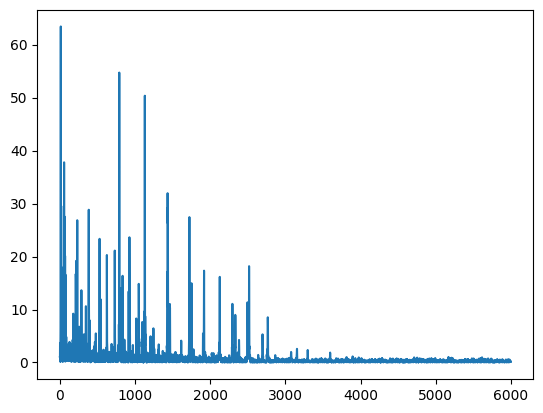

In [ ]:
#plt.plot(df_og["MALDI_binned"]0])
plt.plot(df_og["MALDI_binned"].iloc[0])

In [ ]:
columns_to_keep = [antimicrobial, 'MALDI_binned']
df = df_og[columns_to_keep]

In [ ]:
df

,Cefepime,MALDI_binned
62,S,"[0.9622048557553669, 0.9654783991028986, 3.634..."
83,R,"[3.7593023609854614, 1.9891697436987668, 1.721..."
84,R,"[5.816891786129823, 8.156160476729704, 1.74997..."
163,S,"[1.0185937622416568, 3.3983418531657654, 2.131..."
234,R,"[0.8773673765157095, 0.5829384491421752, 1.183..."
...,...,...
4595,R,"[2.074754195804053, 0.6342150277846585, 1.0452..."
4598,S,"[0.5832165926617959, 1.7320458051573382, 3.242..."
4678,S,"[2.426164670946893, 1.7618432365664165, 2.1901..."
4679,S,"[1.6751718345480067, 2.4543018828498044, 1.040..."


In [ ]:
mapping = {"S": 0, "R":1}
df.loc[:, antimicrobial]= df[antimicrobial].map(mapping)

<ipython-input-27-89b83a6b7bde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, antimicrobial]= df[antimicrobial].map(mapping)
<ipython-input-27-89b83a6b7bde>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, antimicrobial]= df[antimicrobial].map(mapping)


In [ ]:
df

In [ ]:
df.describe()

,Cefepime
count,185.000000
mean,0.286486
std,0.453346
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
print(df.isna().any().any())

False


In [ ]:
df.to_csv(f'/content/drive/MyDrive/TFM/Dataframes/dataframe_{dataset}_{organism}_{antimicrobial}.csv', index=False)

# Data Loading & Visualization

In [7]:
df = pd.read_csv(f'/export/gts_usuarios/pscruz/dataframes/dataframe_{dataset}_{organism}_{antimicrobial}.csv')

In [8]:
def string_a_lista(cadena):
    cadena_sin_corchetes = re.sub(r'\[|\]', '', cadena)
    lista_de_floats = [float(x) for x in cadena_sin_corchetes.split(',')]
    return lista_de_floats

# Convertir cada string de la columna 'lista_strings' a una lista de floats
df['MALDI_binned'] = df['MALDI_binned'].apply(string_a_lista)

In [9]:
df

,Cefepime,MALDI_binned
0,0,"[0.8248382107315309, 3.0178112515541433, 1.433..."
1,0,"[9.474581038449015, 9.698861035949678, 3.80487..."
2,0,"[0.004608966079209764, 0.6014760631883405, 3.5..."
3,0,"[0.42778114998555483, 0.21868961156733036, 2.4..."
4,0,"[0.7016972330483631, 2.923202259959491, 2.5995..."
...,...,...
2146,0,"[0.9257674820201695, 0.6864670043986015, 0.964..."
2147,0,"[1.028744799687224, 1.345631517410544, 0.41952..."
2148,0,"[0.0, 0.06773274963472153, 1.0519639777997278,..."
2149,1,"[1.5762556890171944, 0.9851056195129156, 0.216..."


In [9]:
max_abs = df['MALDI_binned'].apply(max).max()
min_abs = df['MALDI_binned'].apply(min).min()
df['MALDI_binned'] = df['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])

In [11]:
df

,Cefepime,MALDI_binned
0,0,"[0.006266812575097119, 0.022928202469835138, 0..."
1,0,"[0.07198432713594859, 0.07368832276853861, 0.0..."
2,0,"[3.5017202413272836e-05, 0.004569790423585807,..."
3,0,"[0.0032501213634870503, 0.0016615219687722707,..."
4,0,"[0.005331233430709246, 0.022209398696526918, 0..."
...,...,...
2146,0,"[0.007033635472336657, 0.005215519843266102, 0..."
2147,0,"[0.007816018660832896, 0.010223605556872217, 0..."
2148,0,"[0.0, 0.0005146081275506453, 0.007992429301714..."
2149,1,"[0.011975801854209274, 0.007484464472962839, 0..."


In [13]:
porcentaje_susceptible = (df[antimicrobial].value_counts()[0.0] / len(df)) * 100
print("Porcentaje de instancias susceptibles: ", porcentaje_susceptible)
porcentaje_resistente = 100 - porcentaje_susceptible
print("Porcentaje de instancias resistentes: ", porcentaje_resistente)

weight_for_class_0 = len(df) / (df[antimicrobial].value_counts()[0.0])
print("Peso para la clase 0 (Susceptibles): ", weight_for_class_0)
weight_for_class_1 = len(df) / (df[antimicrobial].value_counts()[1.0])
print("Peso para la clase 1 (Resistentes): ", weight_for_class_1)

pos_weight = 1.0/(porcentaje_resistente/100)
print("Pos_weights para clase 1 (Resistente): ", pos_weight)

# Define los pesos de clase
class_weights = {0: weight_for_class_0, 1: weight_for_class_1}
print(class_weights)

Porcentaje de instancias susceptibles:  94.93258949325894
Porcentaje de instancias resistentes:  5.067410506741055
Peso para la clase 0 (Susceptibles):  1.0533790401567091
Peso para la clase 1 (Resistentes):  19.73394495412844
Pos_weights para clase 1 (Resistente):  19.73394495412842
{0: 1.0533790401567091, 1: 19.73394495412844}


In [13]:
# Separación en dos subconjuntos de datos, el test con un tamaño del 20% y sobre el otro 80% se genera el conjunto de validación y entrenamiento
df_train, df_test = train_test_split(df, test_size=0.2, random_state=3, stratify = df[antimicrobial])
# Dentro del subconjunto grande, se
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=3, stratify = df_train[antimicrobial])

# TRAINING SET
X = df_train.drop(antimicrobials, axis=1).values.tolist()
y = df_train[antimicrobial].values.astype('float32')

print(len(X))
print(len(y))

print(X[0])
print(y[0])

tensor_X_train = torch.tensor(X, dtype=torch.float32)
tensor_X_train = tensor_X_train.view(tensor_X_train.shape[0], -1)

tensor_y_train = torch.tensor(y, dtype=torch.float32)

print(tensor_X_train.shape)
print(tensor_y_train.shape)

weight_for_class_0 = len(df) / (df[antimicrobial].value_counts()[0.0])
weight_for_class_1 = len(df) / (df[antimicrobial].value_counts()[1.0])

weights = [0] * len(y)
for idx, row in enumerate(y):
    if row == 0:
      weights[idx] = weight_for_class_0
    else:
      weights[idx] = weight_for_class_1

weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

dataset = TensorDataset(tensor_X_train, tensor_y_train)
batch_size = 16  # Puedes ajustar el tamaño del lote según tus necesidades

features = dataset.tensors[0]
labels = dataset.tensors[1]

# Imprimir las formas de las características y etiquetas
print("Forma de las características (X):", features.shape)
print("Forma de las etiquetas (y):", labels.shape)

trainloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

for batch_idx, (data, target) in enumerate(trainloader):
    print(f"Batch {batch_idx}:")
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)
    # Aquí puedes imprimir más información sobre los datos si lo necesitas

    # Muestra solo las primeras muestras para evitar imprimir demasiados datos
    if batch_idx >= 2:
        break

trainloader_shap = DataLoader(dataset, batch_size=1)

# VALIDATION SET
X = df_valid.drop(antimicrobials, axis=1).values.tolist()
y = df_valid[antimicrobial].values.astype('float32')

tensor_X_val = torch.tensor(X, dtype=torch.float32)
tensor_X_val = tensor_X_val.view(tensor_X_val.shape[0], -1)

tensor_y_val = torch.tensor(y, dtype=torch.float32)

weights = [0] * len(y)
for idx, row in enumerate(y):
    if row == 0:
      weights[idx] = weight_for_class_0
    else:
      weights[idx] = weight_for_class_1

weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

dataset = TensorDataset(tensor_X_val, tensor_y_val)
validloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# TEST SET
X = df_test.drop(antimicrobials, axis=1).values.tolist()
y = df_test[antimicrobial].values.astype('float32')

tensor_X_test = torch.tensor(X, dtype=torch.float32)
tensor_X_test = tensor_X_test.view(tensor_X_test.shape[0], -1)

tensor_y_test = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(tensor_X_test, tensor_y_test)
testloader = DataLoader(dataset, batch_size=batch_size)

1290
1290
[[0.0, 0.0023777752332664976, 0.01178088939637655, 0.010758549947823454, 0.008378525849874882, 0.009297091912444584, 0.006313653819166427, 0.02038804990957195, 0.01613539027410993, 0.010169047216448089, 0.013714631342307557, 0.002775371894554388, 0.0219834607697211, 0.03100936584399259, 0.007505068155062981, 0.0034947196325070488, 0.012466497091214623, 0.013121794887010747, 0.033237373707809964, 0.04839276059624839, 0.02358012178559608, 0.009814189579707913, 0.004431823336644146, 0.009179208492055207, 0.01546479282381053, 0.013363504802400776, 0.023471618214292476, 0.0404552311037503, 0.04667936062185033, 0.029492526569369182, 0.005274091397357114, 0.014810333005368216, 0.02778391850579743, 0.021190904199561333, 0.02749143085546595, 0.025710191456813546, 0.020137849321505915, 0.011790142877476819, 0.013451364635594225, 0.02440818811956107, 0.005111082838893534, 0.0038094511445743435, 0.015166655697354689, 0.009636252419488539, 0.02007801261016558, 0.01001972936690912, 0.00925

In [ ]:
# Si hicieras el trainer sin generator sino directamente con conjuntos (O SI HAY QUE CREARSE OTROS LOADERS, PORQUE VISTO LO VISTO CON EL ERROR ESTE, NO LE GUSTAN LOS LOADERS AL ADVERSARIAL TRAINER DE ABAJO)

# tensor_X_train = tensor_X_train.view(tensor_X_train.shape[0], -1)
# tensor_X_val = tensor_X_val.view(tensor_X_val.shape[0], -1)
# tensor_X_test = tensor_X_test.view(tensor_X_test.shape[0], -1)

# tensor_y_train = tensor_y_train.view(-1)
# tensor_y_val = tensor_y_val.view(-1)
# tensor_y_test = tensor_y_test.view(-1)

# # Mover los datos a la GPU
# tensor_X_train = tensor_X_train.to('cuda').cpu()
# tensor_y_train = tensor_y_train.to('cuda').cpu()

# tensor_X_val = tensor_X_val.to('cuda').cpu()
# tensor_y_val = tensor_y_val.to('cuda').cpu()

# tensor_X_test = tensor_X_test.to('cuda').cpu()
# tensor_y_test = tensor_y_test.to('cuda').cpu()

In [ ]:
# MUESTRO LOS SHAPES DE LOS TENSORES POR SI SIRVE DE ALGO
print(tensor_X_train.shape)
print(tensor_y_train.shape)
print()
print(tensor_X_val.shape)
print(tensor_y_val.shape)

torch.Size([111, 6000])
torch.Size([111])

torch.Size([37, 6000])
torch.Size([37])


In [14]:
pca_entrada = tensor_X_train.view(tensor_X_train.shape[0], -1)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_entrada)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['CLASS'] = tensor_y_train

In [16]:
pca_df

,PC1,PC2,CLASS
0,-0.267709,-0.294423,0.0
1,0.171152,-0.795060,0.0
2,0.122637,0.038372,0.0
3,-0.222228,0.209561,0.0
4,-1.034746,-0.191621,0.0
...,...,...,...
1285,0.055769,0.135677,0.0
1286,-0.206384,-0.169288,0.0
1287,-0.380004,0.484606,0.0
1288,0.093377,0.275464,0.0


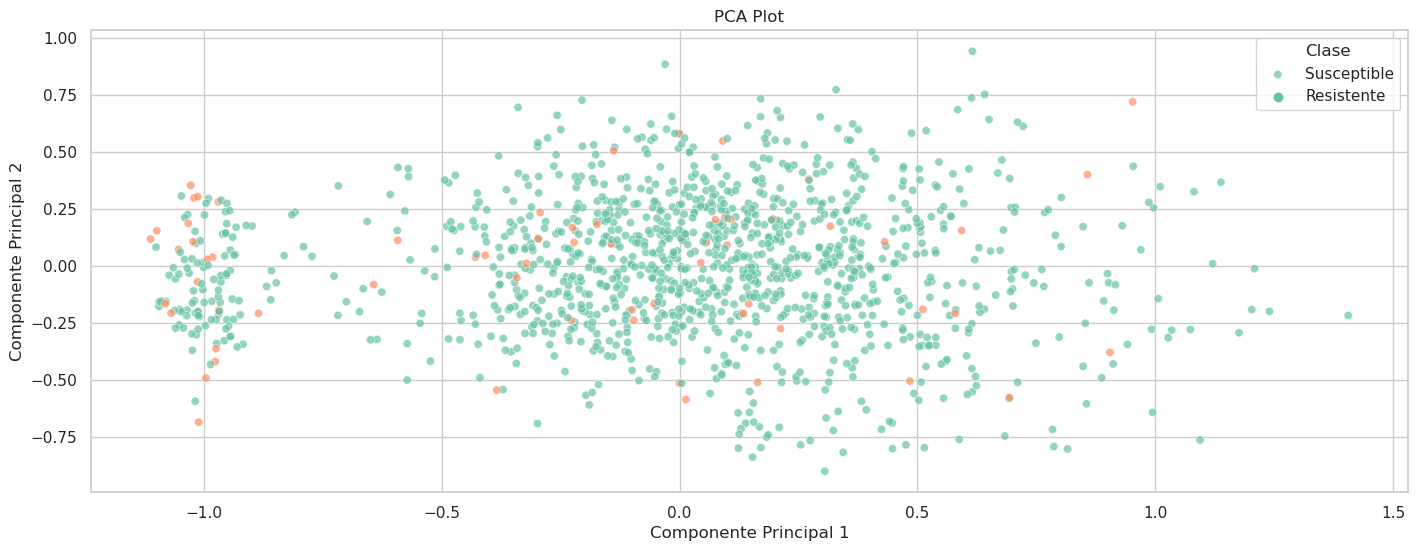

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(17, 6))
sns.scatterplot(x="PC1", y="PC2", hue="CLASS", data=pca_df, palette="Set2", alpha=0.7)
plt.legend(title='Clase', labels = ["Susceptible", "Resistente"])
plt.title('PCA Plot')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# MLP

In [10]:
def normalize(value, max, min):
  return ((value - min) / (max - min))

In [11]:
def invertir_normalizacion(normalizado, min_abs, max_abs):
    original = normalizado * (max_abs - min_abs) + min_abs
    return original

In [12]:
def generate_adversarial_examples(data, labels, adversary_attack):
    data.requires_grad = True  # Habilitar el gradiente para los datos de entrada
    adv_data = adversary_attack(data, labels)
    return adv_data

In [13]:
def generate_adversarial_dataloader(dataloader, adversary_attack):
  # Generar ejemplos adversariales para el conjunto de prueba
  adversarial_examples = []
  adversarial_labels = []
  batch_size = dataloader.batch_size

  for data, labels in dataloader:
      data, labels = data.to(device), labels.to(device)
      adv_data = generate_adversarial_examples(data, labels, adversary_attack)
      adversarial_examples.append(adv_data.cpu().detach().numpy())
      adversarial_labels.append(labels.cpu().detach().numpy())

  # Convertir la lista de ejemplos adversariales y etiquetas en tensores
  adversarial_examples = torch.tensor(np.concatenate(adversarial_examples, axis=0))
  adversarial_labels = torch.tensor(np.concatenate(adversarial_labels, axis=0))

  # Crear un nuevo conjunto de datos adversariales
  adversarial_dataset = TensorDataset(adversarial_examples, adversarial_labels)

  # Crear un DataLoader para el conjunto de datos adversariales
  adversarial_dataloader = DataLoader(adversarial_dataset, batch_size=batch_size)

  return adversarial_dataloader

In [ ]:
# # Generar ejemplos adversariales para el conjunto de prueba
# adversarial_X = []
# adversarial_y = []

# for data, labels in testloader:
#     data, labels = data.to(device), labels.to(device)
#     adv_data = attack(data, labels)  # Generar ejemplos adversariales
#     adversarial_X.append(adv_data.cpu().detach().numpy())
#     adversarial_y.append(labels.cpu().detach().numpy())

# adversarial_X = np.concatenate(adversarial_X)
# adversarial_y = np.concatenate(adversarial_y)

# # Crear un DataLoader para los ejemplos adversariales
# adversarial_dataset = TensorDataset(torch.tensor(adversarial_X), torch.tensor(adversarial_y))
# adversarial_testloader = DataLoader(adversarial_dataset, batch_size=batch_size)

In [14]:
# Early Stopping class, obtained from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [15]:
# BINARY AUROC
def auroc_mlp(model, validloader):
  target = torch.tensor([]).to(device)
  predicted = torch.tensor([]).to(device)

  metric = BinaryAUROC(num_tasks=1)
  for data, labels in validloader:
      data, labels = data.to(device), labels.to(device)
      out = model.forward(data.view(data.shape[0], -1))
      #out = model.softmax(out)
      predicted = torch.cat((predicted, out), 0)
      target = torch.cat((target, labels), 0)
  predicted = predicted.view(predicted.shape[0])
  target = target.view(target.shape[0])
  metric.update(predicted, target)
  auc = metric.compute()
  return auc

In [16]:
# BINARY AUROC
def adversarial_auroc_mlp(model, validloader, attack):
  target = torch.tensor([]).to(device)
  predicted = torch.tensor([]).to(device)

  metric = BinaryAUROC(num_tasks=1)
  for data, labels in validloader:
      data, labels = data.to(device), labels.to(device)
      out = model.forward(data.view(data.shape[0], -1))
      #out = model.softmax(out)
      predicted = torch.cat((predicted, out), 0)
      target = torch.cat((target, labels), 0)
  predicted = predicted.view(predicted.shape[0])
  target = target.view(target.shape[0])
  metric.update(predicted, target)
  auc = metric.compute()
  return auc

In [17]:
class MLP(nn.Module):
    def __init__(self, dimx, num_labels, hidden_layers, dropout=None, batch_norm=False):
      super().__init__()

      self.num_hidden_layers = len(hidden_layers) + 1
      self.layers = [dimx] + hidden_layers + [num_labels]

      self.outputs = nn.ModuleList()
      for i in range(0, self.num_hidden_layers):
        self.outputs.append(nn.Linear(self.layers[i], self.layers[i+1]))

      self.relu = nn.ReLU()

      self.batch_norm = batch_norm
      self.batch_norm_layers = nn.ModuleList()
      if self.batch_norm:
        for b in range(0, self.num_hidden_layers):
          self.batch_norm_layers.append(nn.BatchNorm1d(self.layers[b + 1]))

      self.dropouts = nn.ModuleList()
      if dropout != None:
        for d in range(0, len(dropout)):
          self.dropouts.append(nn.Dropout(p=dropout[d]))

      self.sigmoid = nn.Sigmoid()

    def forward(self, x):

      start_dropout = None
      if len(self.dropouts) != 0:
        start_dropout = self.num_hidden_layers - 1 - len(self.dropouts)

      for l in range(0, self.num_hidden_layers - 1):
        x = self.outputs[l](x)
        if self.batch_norm:
          x = self.batch_norm_layers[l](x)
        x = self.relu(x)
        if start_dropout != None and l >= start_dropout:
          x = self.dropouts[l - start_dropout](x)

      x = self.outputs[-1](x)
      x = self.sigmoid(x)
      # Al final del método forward, x contendrá las probabilidades de que las instancias de entrada pertenezcan a la clase positiva (en un problema de clasificación binaria). La longitud de x será igual al tamaño del lote de datos de entrada que se está procesando en ese momento.
      # El método return x.view(-1) se utiliza para aplanar x en una sola dimensión, lo que es útil si se espera que x represente las probabilidades para un conjunto de datos en lotes.
      #return x
      return x.view(-1)

In [18]:
class MLP_extended(MLP):
  def __init__(self, hidden_layers, dimx=6000, num_labels=1, dropout=None, batch_norm=False, lr=0.001, n_epochs=20, attack_name=None):

    super().__init__(dimx, num_labels, hidden_layers, dropout, batch_norm)
    self.lr = lr
    self.epochs = n_epochs
    self.optim = optim.Adam(self.parameters(), self.lr)

    self.criterion = nn.BCELoss()

    # LOSS EVOLUTION
    self.loss_during_training = []
    self.adv_loss_during_training = []
    self.valid_loss_during_training = []
    self.adv_valid_loss_during_training = []

    # Crear nombre de la carpeta basado en la hora fecha actual y el ataque realizado
    current_date = datetime.now().strftime('%Y-%m-%d')
    folder_name = f"model_saves_{attack_name}_{current_date}"
    self.save_folder = os.path.join(os.getcwd(), folder_name)

    # Crear la carpeta si no existe
    os.makedirs(self.save_folder, exist_ok=True)

  def train_valid_loop(self, trainloader, valloader):
    patience = 150
    earlyStopping = EarlyStopping(patience=patience)
    self.to(device)

    for e in range(int(self.epochs)):
      running_loss = 0.
      for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        self.optim.zero_grad()
        out = self.forward(data.view(data.shape[0], -1))
        loss = self.criterion(out.view(-1), labels)
        running_loss += loss.item()
        loss.backward()
        self.optim.step()

      self.loss_during_training.append(running_loss/len(trainloader))
      wandb.log({"training_loss":running_loss/len(trainloader)})

      torch.save(self.state_dict(), os.path.join(self.save_folder, f'model_weights_{e}.pth'))

      with torch.no_grad():
        self.eval()
        val_run_loss = 0.
        for validdata, validlabels in valloader:
          validdata, validlabels = validdata.to(device), validlabels.to(device)
          validout = self.forward(validdata.view(validdata.shape[0], -1))
          validloss = self.criterion(validout.view(-1), validlabels)
          val_run_loss += validloss.item()

        self.valid_loss_during_training.append(val_run_loss/len(valloader))

        wandb.log({"validation_loss":val_run_loss/len(valloader)})

        earlyStopping(self.valid_loss_during_training[-1])

      self.train()

      if e % 1 == 0:
        print("training loss after %d epochs: %f" %(e, self.loss_during_training[-1]))
        print("validation loss after %d epochs: %f\n" %(e, self.valid_loss_during_training[-1]))

      if earlyStopping.early_stop:
        self.load_state_dict(torch.load(os.path.join(self.save_folder, f'model_weights_{e - patience}.pth')))
        print('Stopping training due to early stopping')
        break

  def train_valid_loop_with_adversarial(self, trainloader, valloader, adversary_attack):
    patience = 150
    earlyStopping = EarlyStopping(patience=patience)
    self.to(device)

    for e in range(int(self.epochs)):
      running_loss = 0.
      adv_running_loss = 0.

      # Training with benign examples
      for data, labels in trainloader:
          data, labels = data.to(device), labels.to(device)
          self.optim.zero_grad()
          out = self.forward(data.view(data.shape[0], -1))
          loss = self.criterion(out.view(-1), labels)
          running_loss += loss.item()
          loss.backward()
          self.optim.step()

      # Generate adversarial examples and train with them
      print("Adversarial training currently undergoing...")
      for data, labels in trainloader:
          data, labels = data.to(device), labels.to(device)
          adv_data = generate_adversarial_examples(data, labels, adversary_attack)
          self.optim.zero_grad()
          adv_out = self.forward(adv_data.view(adv_data.shape[0], -1))
          loss = self.criterion(adv_out.view(-1), labels)
          adv_running_loss += loss.item()
          loss.backward()
          self.optim.step()

      print("Adversarial training epoch finished succesfully.")
      self.loss_during_training.append(running_loss/len(trainloader))
      self.adv_loss_during_training.append(adv_running_loss/len(trainloader))

      wandb.log({"training_loss":running_loss/len(trainloader)})
      wandb.log({"adv_training_loss":adv_running_loss/len(trainloader)})

      torch.save(self.state_dict(), os.path.join(self.save_folder, f'model_weights_{e}.pth'))

      with torch.no_grad():
        self.eval()
        val_run_loss = 0.
        adv_val_run_loss = 0.
        for validdata, validlabels in valloader:
          validdata, validlabels = validdata.to(device), validlabels.to(device)
          validout = self.forward(validdata.view(validdata.shape[0], -1))
          validloss = self.criterion(validout.view(-1), validlabels)
          val_run_loss += validloss.item()

      for validdata, validlabels in valloader:
        validdata, validlabels = validdata.to(device), validlabels.to(device)
        adv_validdata = generate_adversarial_examples(validdata, validlabels, adversary_attack)
        adv_validout = self.forward(adv_validdata.view(adv_validdata.shape[0], -1))
        adv_validloss = self.criterion(adv_validout.view(-1), validlabels)
        adv_val_run_loss += adv_validloss.item()

      self.valid_loss_during_training.append(val_run_loss/len(valloader))
      self.adv_valid_loss_during_training.append(adv_val_run_loss/len(valloader))

      wandb.log({"validation_loss":val_run_loss/len(valloader)})
      wandb.log({"adv_validation_loss":adv_val_run_loss/len(valloader)})

      earlyStopping(self.valid_loss_during_training[-1])

      self.train()

      if e % 1 == 0:
        print("training loss after %d epochs: %f" %(e, self.loss_during_training[-1]))
        print("validation loss after %d epochs: %f\n" %(e, self.valid_loss_during_training[-1]))

      if earlyStopping.early_stop:
        self.load_state_dict(torch.load(os.path.join(self.save_folder, f'model_weights_{e - patience}.pth')))
        print('Stopping training due to early stopping')
        break

  def accuracy(self, dataloader, types="Test"):
    target = []
    predicted = []
    self.to(device)

    with torch.no_grad():
      self.eval()
      for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        out = self.forward(data.view(data.shape[0], -1))
        #out = self.softmax(out)
        target.extend(labels.cpu().numpy())
        predicted.extend(out.cpu().numpy())
      target = np.array(target)
      predicted = np.where(np.array(predicted) < 0.5, 0, 1)
      print("ACCURACY")
      print("Target")
      print(target)
      print("Predicted")
      print(predicted)
      accuracy = balanced_accuracy_score(target, predicted)

      self.train()
      return accuracy, target, predicted

  def attack_success_ratio(self, adversarial_dataloader):
    attack_success_count = 0
    total_samples = 0

    with torch.no_grad():
      self.eval()
      for inputs, labels in adversarial_dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          # Calcular las probabilidades de pertenencia a la clase 1
          probabilities = self.forward(inputs).squeeze()  # Obtener las probabilidades (salida única)
          
          # Convertir las probabilidades en predicciones (0 o 1)
          predicted = (probabilities >= 0.5).int()  # Clasificar como clase 1 si la probabilidad >= 0.5
          # Contar ejemplos clasificados incorrectamente como resultado del ataque adversarial
          attack_success_count += (predicted != labels).sum().item()
          total_samples += labels.size(0)

      print("Attack Success Ratio")
      print("predicted")
      print(predicted)
      print("labels")
      print(labels)
      attack_success_rate = attack_success_count / total_samples
      self.train()  # Volver al modo de entrenamiento
      return attack_success_rate

  def fooling_ratio(self, dataloader, adversarial_dataloader):
      num_samples = len(dataloader.dataset)
      num_fooled = 0
      with torch.no_grad():
          self.eval()
          for original_batch, adversarial_batch in zip(dataloader, adversarial_dataloader):
              original_inputs, _ = original_batch
              adversarial_inputs, _ = adversarial_batch

              # Move tensors to device
              original_inputs = original_inputs.to(device)
              adversarial_inputs = adversarial_inputs.to(device)

              # Predictions on original and adversarial inputs
              original_probs = self.forward(original_inputs).squeeze()
              adversarial_probs = self.forward(adversarial_inputs).squeeze()

              # Convert probabilities to predictions (assuming threshold of 0.5)
              original_predicted = (original_probs >= 0.5).int()
              adversarial_predicted = (adversarial_probs >= 0.5).int()
              
              # Calculate number of differences in predictions
              num_fooled += torch.sum(original_predicted != adversarial_predicted).item()
      print("Fooling ratio")
      print("Original predicted")
      print(original_predicted)
      print("Adversarial predicted")
      print(adversarial_predicted)
      self.train()  # Volver al modo de entrenamiento
      return num_fooled / num_samples


In [27]:
# HIPER-PARAMETERS SETTING
config = wandb.config
lr = 0.000075
epochs = 100
dropout = [0.1]
hidden_layers = [16]
batch_norm = False
dimx = 6000

NOTE: Probar con input_shape (1,6000), (6000,1), (6000,) y (16,6000) -> este seguramente no funcione.
El dataset tiene que tener NCHW format.
Revisar siguiente link: https://medium.com/@slavadubrov/adversarial-attacks-and-defenses-in-machine-learning-1b649791816a (hacen cosas con el adversarial trainer que pueden ser interesantes)
Otra cosa que igual sirve para algo: https://stackoverflow.com/questions/63223579/failed-to-generate-adversarial-examples-using-trained-nsga-net-pytorch-models
Otra cosa interesante: https://github.com/Harry24k/MAIR - https://github.com/Harry24k/MAIR/blob/main/demos/Train%20and%20Evaluation.ipynb
Esto para hacerlo directamente sin librerías: https://medium.com/@madadihosyn99/generating-adversarial-examples-with-fast-gradient-sign-method-fgsm-in-pytorch-a-step-by-step-a423537628dd

In [28]:
multi_layer = MLP_extended(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm)
multi_layer.to(device)

# Definimos el ataque adversario:
epsilon=0.03
alpha=0.01
iterations=40
overshoot = 0.01

adversary_attack = torchattacks.PGD(multi_layer, eps=epsilon, alpha=alpha, steps=iterations)
#adversary_attack = torchattacks.FGSM(multi_layer, eps=epsilon) --------------------------------------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.DeepFool(multi_layer, steps=iterations, overshoot = overshoot)
#adversary_attack = torchattacks.FAB(multi_layer, norm = 'Linf', seed=42, n_classes=2) ---------------------------------------- FUNCIONA RARO (si quitas el view(-1) final en el forward de MLP), la evolución de loss es rara (no va con picos, es muy smooth) LA PERTURBACIÓN MAXIMA SALE 0???
#adversary_attack = torchattacks.CW(multi_layer)
#adversary_attack = torchattacks.BIM(multi_layer, eps=epsilon, alpha=alpha, steps=iterations) ---------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.TPGD(multi_layer, eps=epsilon, alpha=alpha, steps=iterations) --------------------------------- FUNCIONA (si quitas el view(-1) final en el forward de MLP), además la evolución de loss va dpm (todo baja muy rápido)
#adversary_attack = torchattacks.EOTPGD(multi_layer) --------------------------------------------------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.MIFGSM(multi_layer)
#adversary_attack = torchattacks.NIFGSM(multi_layer)
#adversary_attack = torchattacks.APGD(multi_layer)
#adversary_attack = torchattacks.Square(multi_layer)
#adversary_attack = torchattacks.AutoAttack(multi_layer, n_classes=2)
#adversary_attack = torchattacks.OnePixel(multi_layer)
#adversary_attack = torchattacks.SparseFool(multi_layer)
#adversary_attack = torchattacks.TIFGSM(multi_layer)
#adversary_attack = torchattacks.Jitter(multi_layer)
#adversary_attack = torchattacks.UPGD(multi_layer, eps=epsilon, alpha=alpha, steps=iterations)
#adversary_attack = torchattacks.SPSA(multi_layer)
#adversary_attack = torchattacks.GN(multi_layer) -------------------------------------------------------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.JSMA(multi_layer)
#adversary_attack = torchattacks.EADEN(multi_layer)
#adversary_attack = torchattacks.EADL1(multi_layer)
#adversary_attack = torchattacks.FFGSM(multi_layer, eps=epsilon) ---------------------------------------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.PGDRS(multi_layer)
#adversary_attack = torchattacks.RFGSM(multi_layer) ----------------------------------------------------------------------------- FUNCIONA (con el view)
#adversary_attack = torchattacks.VNIFGSM(multi_layer)
#adversary_attack = torchattacks.VMIFGSM(multi_layer)
#adversary_attack = torchattacks.Pixle(multi_layer)
#adversary_attack = torchattacks.DIFGSM(multi_layer)
#wandb.init()
# Se entrena el modelo con el conjunto de datos de siempre de MALDI-TOF
multi_layer.train_valid_loop_with_adversarial(trainloader, validloader, adversary_attack)

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 0 epochs: 0.697543
validation loss after 0 epochs: 0.695521

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 1 epochs: 0.693677
validation loss after 1 epochs: 0.693603

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 2 epochs: 0.692566
validation loss after 2 epochs: 0.698883

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 3 epochs: 0.686703
validation loss after 3 epochs: 0.691350

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 4 epochs: 0.691019
validation loss after 4 epochs: 0.692395

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 5 epochs: 0

KeyboardInterrupt: 

In [ ]:
print(tensor_X_train.shape)
print(tensor_y_train.shape)

torch.Size([111, 6000])
torch.Size([111])


In [ ]:
print(outputs.shape)
attack_success_count = 0
total_samples = 0

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Generar ejemplo adversarial
    perturbed_inputs = adversary_attack(inputs, labels)

    # Calcular las predicciones del modelo en el ejemplo adversarial
    outputs = multi_layer(perturbed_inputs)
    _, predicted = torch.max(outputs, dim=0)

    # Contar ejemplos clasificados incorrectamente después de la perturbación
    attack_success_count += (predicted != labels).sum().item()
    total_samples += labels.size(0)

attack_success_rate = attack_success_count / total_samples
print(f"Attack Success Rate: {attack_success_rate:.4f}")


torch.Size([5])
Attack Success Rate: 1.0000


In [ ]:
adversarial_testloader = generate_adversarial_dataloader(testloader, adversary_attack)
print(multi_layer.attack_success_ratio(adversarial_testloader))

PREDICTED: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)
LABELS: tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       device='cuda:0')
PREDICTED: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)
LABELS: tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
PREDICTED: tensor([1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
LABELS: tensor([0., 0., 0., 0., 1.], device='cuda:0')
0.7027027027027027


**RELEVANTE PARA TPGD** - Maximum Perturbation Distance (encuentra perturbaciones extremadamente bajas)

In [ ]:
max_perturbation_distance = 0.0

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Generar ejemplo adversarial
    perturbed_inputs = adversary_attack(inputs, labels)

    # Calcular la norma infinito (máxima magnitud de perturbación) entre los ejemplos originales y perturbados
    perturbation = (perturbed_inputs - inputs).view(inputs.size(0), -1)
    perturbation_norm = torch.norm(perturbation, p=float('inf'), dim=1)

    # Obtener la máxima perturbación entre todos los ejemplos
    max_perturbation = perturbation_norm.max().item()
    if max_perturbation > max_perturbation_distance:
        max_perturbation_distance = max_perturbation

print(f"Maximum Perturbation Distance: {max_perturbation_distance:.4f}")

Maximum Perturbation Distance: 0.00000000000000000000000000000000


In [ ]:
adversarial_trainloader = generate_adversarial_dataloader(trainloader, adversary_attack)
adversarial_validloader = generate_adversarial_dataloader(validloader, adversary_attack)
adversarial_testloader = generate_adversarial_dataloader(testloader, adversary_attack)

def calculate_fooling_ratio(model, dataloader, adversarial_dataloader):
    num_samples = len(dataloader.dataset)
    num_fooled = 0
    with torch.no_grad():
        model.eval()
        for original_batch, adversarial_batch in zip(dataloader, adversarial_dataloader):
            original_inputs, _ = original_batch
            adversarial_inputs, _ = adversarial_batch

            # Move tensors to device
            original_inputs = original_inputs.to(device)
            adversarial_inputs = adversarial_inputs.to(device)

            # Predictions on original and adversarial inputs
            original_probs = model(original_inputs).squeeze()
            adversarial_probs = model(adversarial_inputs).squeeze()

            # Convert probabilities to predictions (assuming threshold of 0.5)
            original_predicted = (original_probs >= 0.5).int()
            adversarial_predicted = (adversarial_probs >= 0.5).int()
            print("ORIGINAL PREDS:", original_predicted)
            print("ADVERSARIAL PREDS:", adversarial_predicted)
            print("DIFFERENCES: ", torch.sum(original_predicted != adversarial_predicted).item())

            # Calculate number of differences in predictions
            num_fooled += torch.sum(original_predicted != adversarial_predicted).item()

    return num_fooled / num_samples

fooling_ratio_train = calculate_fooling_ratio(multi_layer, trainloader, adversarial_trainloader)
fooling_ratio_val = calculate_fooling_ratio(multi_layer, validloader, adversarial_validloader)
fooling_ratio_test = calculate_fooling_ratio(multi_layer, testloader, adversarial_testloader)
print(fooling_ratio_train)
print(fooling_ratio_val)
print(fooling_ratio_test)

ORIGINAL PREDS: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)
ADVERSARIAL PREDS: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0',
       dtype=torch.int32)
DIFFERENCES:  7
ORIGINAL PREDS: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)
ADVERSARIAL PREDS: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0',
       dtype=torch.int32)
DIFFERENCES:  5
ORIGINAL PREDS: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)
ADVERSARIAL PREDS: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0',
       dtype=torch.int32)
DIFFERENCES:  7
ORIGINAL PREDS: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)
ADVERSARIAL PREDS: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0',
       dtype=torch.int32)
DIFFERENCES:

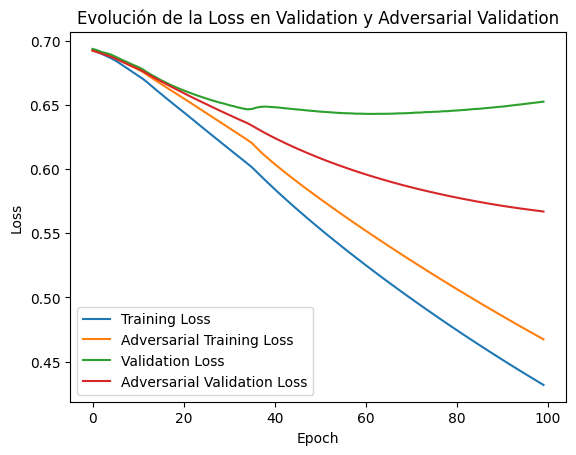

In [ ]:

# ---------------------------------------------------- TRAINING -----------------------------------------------------

plt.plot(range(len(multi_layer.loss_during_training)), multi_layer.loss_during_training, label='Training Loss')
plt.plot(range(len(multi_layer.adv_loss_during_training)), multi_layer.adv_loss_during_training, label='Adversarial Training Loss')

# --------------------------------------------------- VALIDATION ---------------------------------------------------

plt.plot(range(len(multi_layer.valid_loss_during_training)), multi_layer.valid_loss_during_training, label='Validation Loss')
plt.plot(range(len(multi_layer.adv_valid_loss_during_training)), multi_layer.adv_valid_loss_during_training, label='Adversarial Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de la Loss en Validation y Adversarial Validation')
plt.legend()
plt.show()

In [ ]:
print('---------------------------------- EVALUACIÓN CON DATOS BENIGNOS  (TRAIN Y VAL) ----------------------------------')

print("Datos benignos:")
multi_layer.accuracy(trainloader, "Train")
multi_layer.accuracy(validloader, "Validation")
print("Validation set AUC: ", auroc_mlp(multi_layer, validloader))

print("Ejemplos adversarios:")
# Generamos los dataloaders adversarios
adversarial_trainloader = generate_adversarial_dataloader(trainloader, adversary_attack)
adversarial_validloader = generate_adversarial_dataloader(validloader, adversary_attack)

multi_layer.accuracy(adversarial_trainloader, "Adversarial Train")
multi_layer.accuracy(adversarial_validloader, "Adversarial Validation")

print("Adversarial Validation set AUC: ", auroc_mlp(multi_layer, adversarial_validloader))

---------------------------------- EVALUACIÓN CON DATOS BENIGNOS  (TRAIN Y VAL) ----------------------------------
Datos benignos:
Train accuracy 0.796078
Validation accuracy 0.741176
Validation set AUC:  tensor(0.9235, dtype=torch.float64)
Ejemplos adversarios:
Adversarial Train accuracy 0.573897
Adversarial Validation accuracy 0.570513
Adversarial Validation set AUC:  tensor(0.6795, dtype=torch.float64)


---------------------------------- EVALUACIÓN CON TEST ----------------------------------
AUC:  tensor(0.7867, dtype=torch.float64)
Test accuracy 0.793706
ACC:  0.7937062937062938
MATRIZ DE CONFUSIÓN CON DATOS BENIGNOS


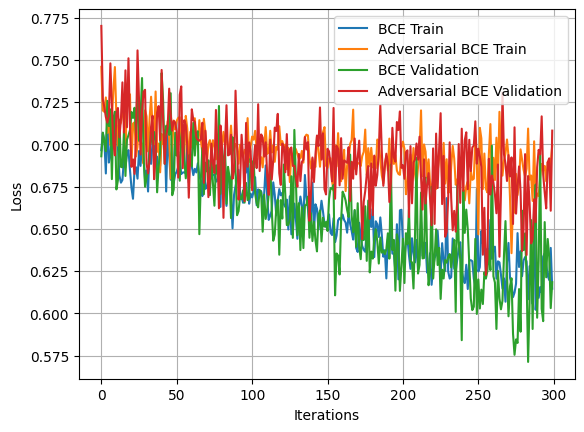

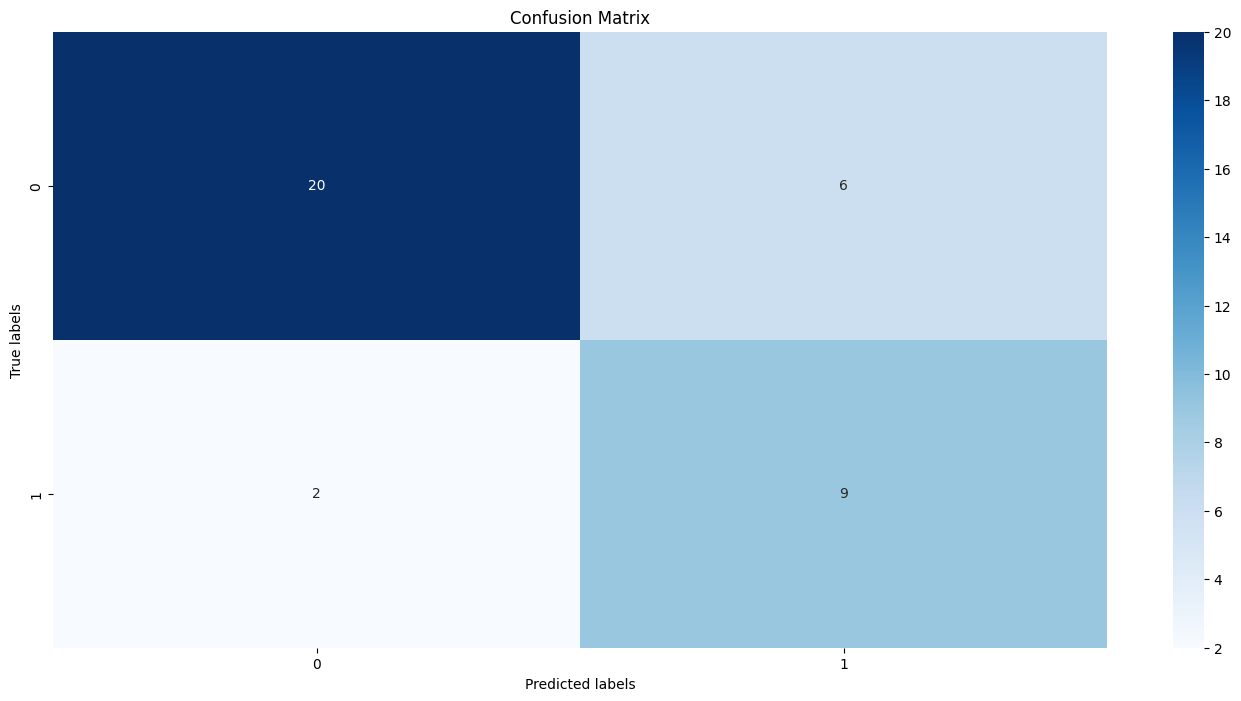

In [ ]:
# NOTE: Lo importante de verdad:

print('---------------------------------- EVALUACIÓN CON TEST ----------------------------------')

print("AUC: ", auroc_mlp(multi_layer, testloader))
# wandb.log({"auc":auroc_mlp(multi_layer, testloader)})

accuracy, true_labels, predicted_labels = multi_layer.accuracy(testloader)
# wandb.log({"acc":accuracy})
print("ACC: ", accuracy)

print('MATRIZ DE CONFUSIÓN CON DATOS BENIGNOS')
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotear resultados durante el entrenamiento

plt.plot(multi_layer.loss_during_training, label='BCE Train')
plt.plot(multi_layer.adv_loss_during_training, label='Adversarial BCE Train')
plt.plot(multi_layer.valid_loss_during_training, label='BCE Validation')
plt.plot(multi_layer.adv_valid_loss_during_training, label='Adversarial BCE Validation')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid()
# plt.savefig('/content/drive/MyDrive/IA en Salud/MALDI-TOF/loss_plot.png')
# wandb.log({"Plot de loss": wandb.Image("/content/drive/MyDrive/IA en Salud/MALDI-TOF/loss_plot.png")})
plt.show()
classes = [str(i) for i in range(2)]
plt.figure(figsize=(17, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# plt.savefig('/content/drive/MyDrive/IA en Salud/MALDI-TOF/confusion_matrix_weighted_loss.png')
# wandb.log({"Matriz de confusión con Weighted Loss": wandb.Image("/content/drive/MyDrive/IA en Salud/MALDI-TOF/confusion_matrix_weighted_loss.png")})
plt.show()

[0.37191567 1.0810655  0.45277578 ... 0.18499534 0.16106208 0.14852372]
(6000,)
[0.37191567 1.0810655  0.45277578 ... 0.18499534 0.16106208 0.14852372]
(6000,)


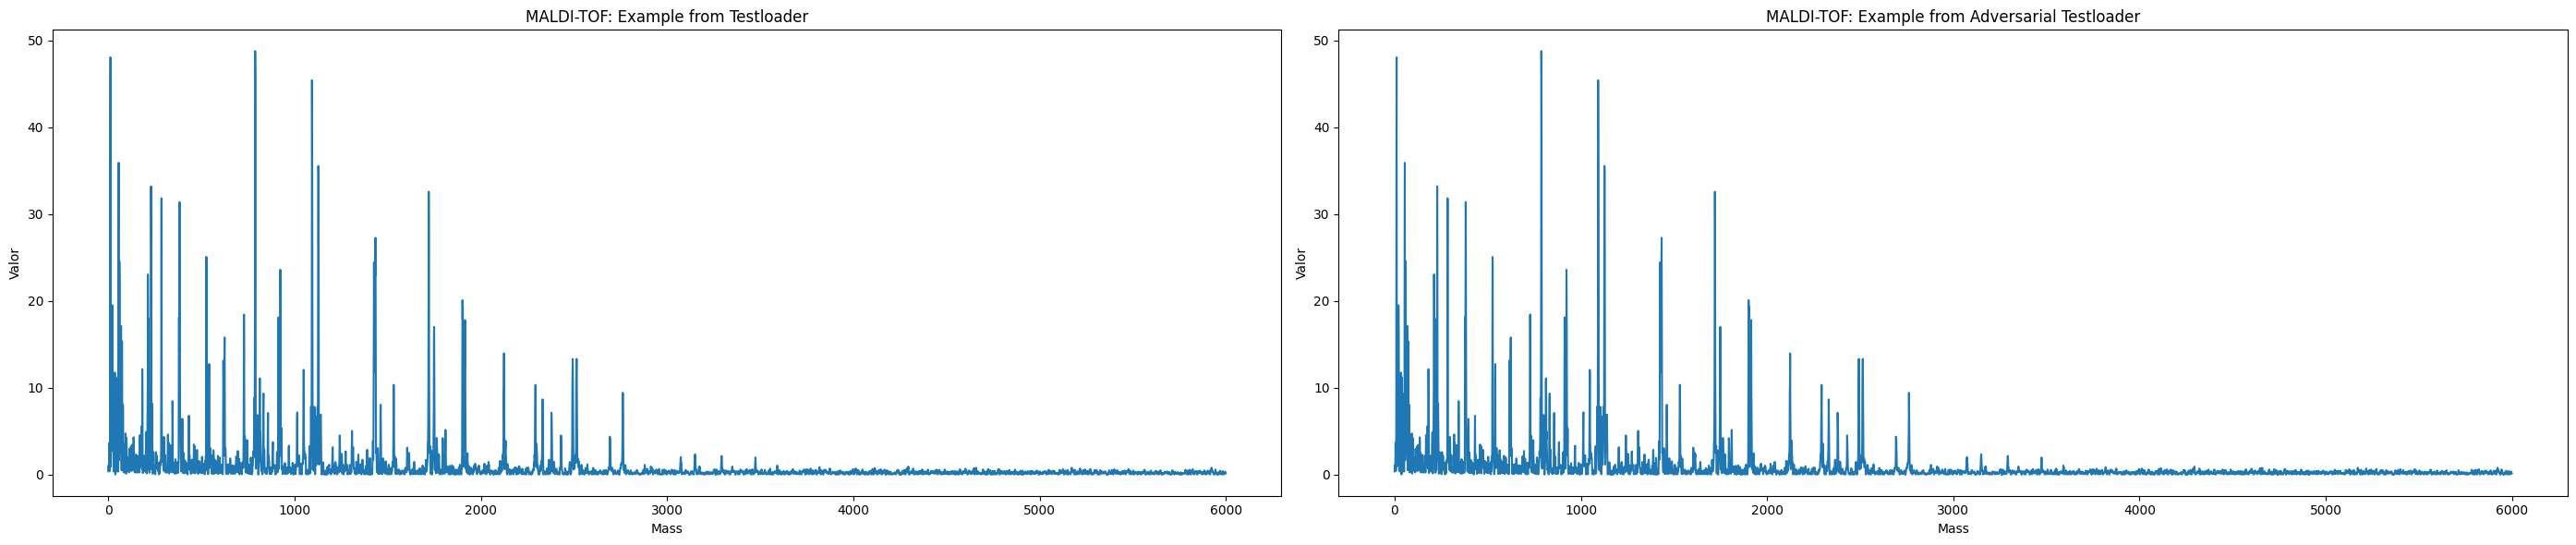

In [ ]:
# -----------------------------------------------------------------  PLOTEAR DIFERENCIAS ENTRE EJEMPLOS BENIGNOS Y ADVERSARIOS -------------------------------------------------------------

# Obtener un lote de datos de testloader
data_iter = iter(testloader)
data, labels = next(data_iter)

# Obtener un lote de datos de adversarial_testloader
adversarial_testloader = generate_adversarial_dataloader(testloader, adversary_attack)
adversarial_data_iter = iter(adversarial_testloader)
adversarial_data, adversarial_labels = next(adversarial_data_iter)

# Invierte la normalización para las imágenes del testloader
denorm_data = [invertir_normalizacion(maldi.numpy().squeeze(), min_abs, max_abs) for maldi in data]

# Invierte la normalización para las imágenes del adversarial_testloader
adversarial_denorm_data = [invertir_normalizacion(adversarial_maldi.numpy().squeeze(), min_abs, max_abs) for adversarial_maldi in adversarial_data]

print(denorm_data[0])
print(denorm_data[0].shape)
print(adversarial_denorm_data[0])
print(adversarial_denorm_data[0].shape)

# Visualizar un ejemplo del testloader
plt.figure(figsize=(28, 6))
plt.subplot(1, 2, 1)
plt.title('MALDI-TOF: Example from Testloader')
plt.plot(denorm_data[0])  # Plotear los datos originales
plt.xlabel('Mass')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y

# Visualizar un ejemplo del adversarial_testloader
plt.subplot(1, 2, 2)
plt.title('MALDI-TOF: Example from Adversarial Testloader')
plt.plot(adversarial_denorm_data[0])  # Plotear los datos adversarios
plt.xlabel('Mass')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y

plt.tight_layout()  # Ajustar el diseño de los gráficos
plt.show()

In [ ]:
# Obtener 5 índices aleatorios del testloader
random_indices = random.sample(range(len(testloader)), 5)

plt.figure(figsize=(28, 30))

for i, index in enumerate(random_indices, 1):
    # Obtener un lote de datos de testloader en el índice aleatorio
    data, labels = testloader.dataset[index]
    # Obtener un lote de datos de adversarial_testloader en el índice aleatorio
    adversarial_data, adversarial_labels = adversarial_testloader.dataset[index]

    # Invierte la normalización para las imágenes del testloader
    denorm_data = invertir_normalizacion(data.numpy().squeeze(), min_abs, max_abs)

    # Invierte la normalización para las imágenes del adversarial_testloader
    adversarial_denorm_data = invertir_normalizacion(adversarial_data.numpy().squeeze(), min_abs, max_abs)

    # Visualizar los ejemplos
    plt.subplot(5, 2, 2*i-1)
    plt.plot(denorm_data)
    plt.title(f'Example {index}: Original')
    plt.xlabel('Mass')
    plt.ylabel('Valor')

    plt.subplot(5, 2, 2*i)
    plt.plot(adversarial_denorm_data)
    plt.title(f'Example {index}: Adversarial')
    plt.xlabel('Mass')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

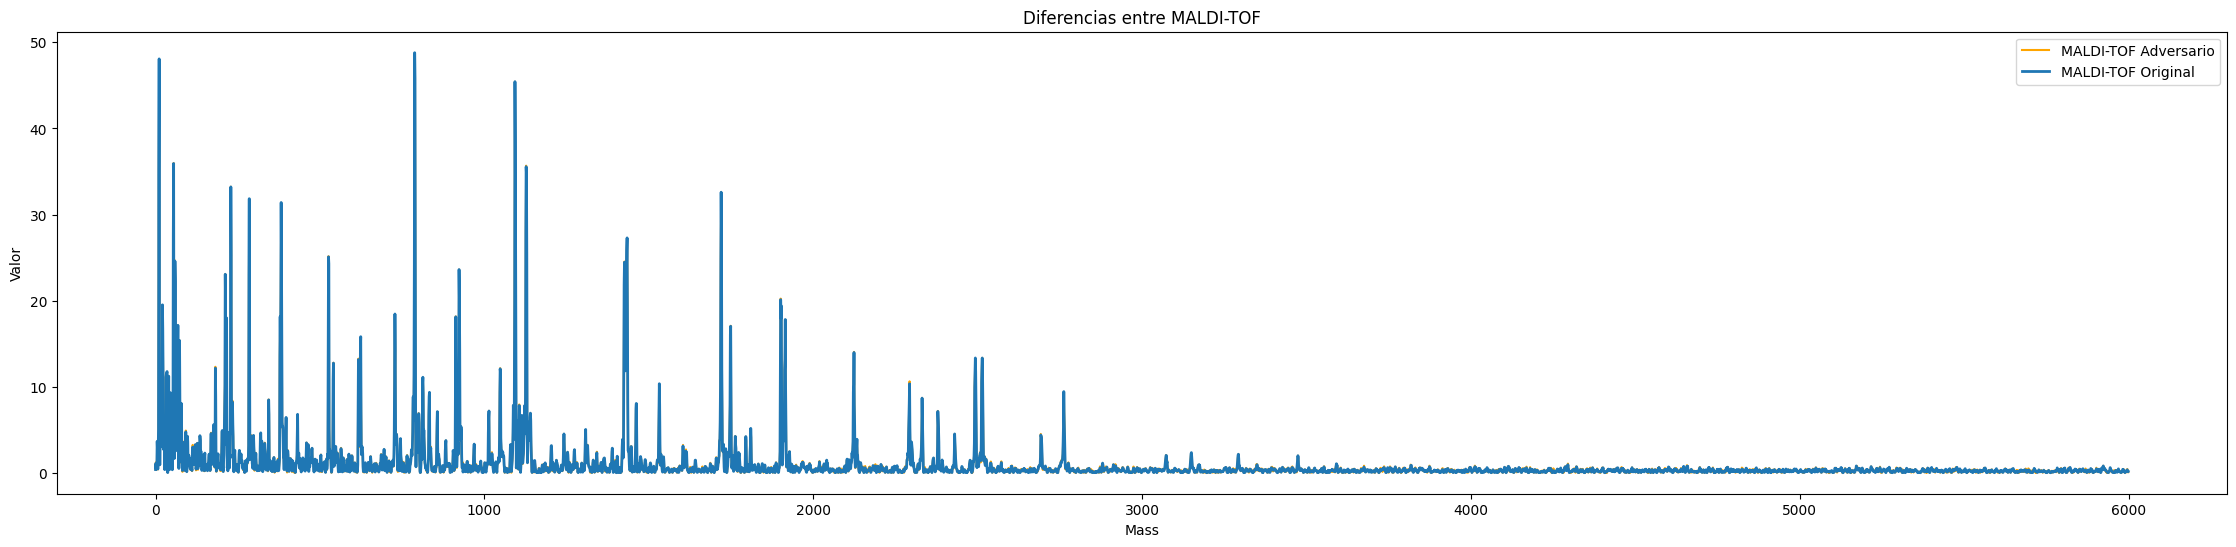

In [ ]:
plt.figure(figsize=(28, 6))
plt.title('Diferencias entre MALDI-TOF')


# Plotear la diferencia del adversario frente al original
plt.plot(denorm_data[0] + (adversarial_denorm_data[0] - denorm_data[0]), color='orange', label='MALDI-TOF Adversario')

# Plotear los datos originales en rojo y con una línea más gruesa
plt.plot(denorm_data[0], linewidth=2, label='MALDI-TOF Original')

plt.xlabel('Mass')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y
plt.legend()  # Mostrar la leyenda

plt.show()

In [ ]:
# Obtener 5 instancias aleatorias del testloader
random_indices = random.sample(range(len(testloader)), 5)
original_samples = [data[i] for i in random_indices]

# Obtener las contrapartes adversarias correspondientes
adversarial_samples = []
for index in random_indices:
    adversarial_data, _ = next(iter(adversarial_testloader))
    adversarial_samples.append(adversarial_data)

# Invierte la normalización para las imágenes originales
denorm_original_samples = [invertir_normalizacion(maldi.numpy().squeeze(), min_abs, max_abs) for maldi in original_samples]

# Invierte la normalización para las imágenes adversarias
denorm_adversarial_samples = [invertir_normalizacion(adversarial_maldi.numpy().squeeze(), min_abs, max_abs) for adversarial_maldi in adversarial_samples]

# Crear un gráfico para plotear las diferencias
plt.figure(figsize=(10, 6))

for i in range(5):
    # Plotear la diferencia del adversario frente al original
    plt.plot(denorm_original_samples[i] + (denorm_adversarial_samples[i] - denorm_original_samples[i]), label=f'Sample {i+1}')

# Plotear los datos originales en rojo y con una línea más gruesa
plt.plot(denorm_original_samples[i], linewidth=2, color='red', label='Original')

plt.xlabel('Mass')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y
plt.legend()  # Mostrar la leyenda

plt.show()

# SWEEP


*   Normalizar Epsilon (con el cálculo del max abs y el min abs) -> hecho

*   Todas las métricas adversarial van muy mal (todo ronda muy muy cerca del 0 o sino 1, lo cual significa que algo hay mal)

*   Arreglar el SMOTE (lo de que tiene 3 dimensiones es porque hay listas redundantes dentro de listas) -> hecho

*   Meter métricas de monitorización especíalizadas para ver el rendimiento del adversarial

In [19]:
denorm_epsilon = [0.03, 0.05, 0.1, 0.25, 0.5]
epsilon = [normalize(value, max_abs ,min_abs) for value in denorm_epsilon]
print(epsilon)

[0.00022792879234604884, 0.0003798813205767481, 0.0007597626411534962, 0.0018994066028837403, 0.0037988132057674806]


**Importante** clarificar que la ejecución de este código está pensada para que se ejecute un único ataque por sweep porque si no, como cada ataque recibe parámetros distintos, van a haber ejecuciones que se van a repetir sin efectos al ir cambiando esos valores que dan igual. Además, así será posible observar más fácilmente el rendimiento de cada uno de los ataques y qué parámetros tienen más efecto en cada uno de ellos por separado.

**TODO**: PASAR EL DATASET DE TENER SIZE 16,6000) A SIZE (16,1,1,6000) Y PROBAR CON PBDL2 Y CON DEEPFOOL

In [ ]:
'attack': {
    'values': ['PGD_Linf', 'FGSM', 'DeepFool', 'CW', 'FAB']
  }
  # NOTE: PGD_L2 NO FUNCIONA CON ARRAYS UNIDIMENSIONALES EN ESTA LIBRERÍA (NO SÉ COMO FUNCIONA ASIQUE NO SÉ SI FUNCIONARÁ CON OTRAS LIBRERÍAS)

In [20]:
sweep_config = {
    'method': 'grid'
    }

metric = {
    'name': 'auc_test',
    'goal': 'maximize'
    }

sweep_config['metric'] = metric

# parameters_dict = {
#     'hidden_layers': {
#         'values': [[128, 256, 256], [32,32,32], [32,64,128], [64,32,16]] #, [256,64], [128,64], [256], [64,128]]
#         },
#     'dropout': {
#           'values': [[0.2, 0.3], [0.1, 0.1], [0.5, 0.5], [0.3], [0.2], [0.1], None ]
#         },
#     'epochs':{
#           'value':15
#     },
#     'lr': {
#         'values': [1e-3, 5e-4, 1e-4, 7.5e-5]
#       },
#     'batch_norm': {
#         'values': [True, False]
#     },
#     'antimicrobial': {
#         'value': 'Cefepime'
#       },
#     'attack': {
#         'values': ['FGSM'] #['PGD_Linf', 'FGSM', 'DeepFool', 'CW', 'FAB']
#       },
#     'epsilon': {
#         'values': epsilon
#       },
#     'alpha': {
#         'values': [0.01, 0.05, 0.1, 0.25, 0.5]
#       },
#     'iterations': {
#         'values': [50, 100, 150]
#       },
#     'smote': {
#         'values': [True]
#       },
#     'overshoot':{
#         'values':[0.01, 0.02, 0.04]
#     },
#     'norm':{
#         'values':['Linf', 'L2', 'L1']
#     },
#     'n_restarts':{
#         'values':[1,2]
#     },
#     'alpha_max':{
#         'values':[0.1, 0.05, 0.02]
#     },
#     'eta':{
#         'values':[1, 1.05, 1.15]
#     },
#     'beta':{
#         'values':[0.8, 0.9, 0.95]
#     },
#     'c':{
#         'values':[1, 1.5, 2]
#     },
#     'adversary_lr':{
#         'values':[1e-2, 5e-3]
#     },
#     'confidence':{
#         'values':[0, 0.25]
#     },
#     }


parameters_dict = {
    'hidden_layers': {
        'values': [[128, 256, 256], [32,32,32], [32,64,128], [64,32,16]] #, [256,64], [128,64], [256], [64,128]]
        },
    'dropout': {
          'values': [[0.2, 0.3], [0.1, 0.1], [0.5, 0.5], [0.3], [0.2], [0.1], None ]
        },
    'epochs':{
          'value':10
    },
    'lr': {
        'values': [1e-3, 5e-4, 1e-4, 7.5e-5]
      },
    'batch_norm': {
        'values': [True, False]
    },
    'antimicrobial': {
        'value': 'Cefepime'
      },
    'smote': {
        'values': [True, False]
      },
    'attack': {
        'values': ['PGD_Linf'] #['PGD_Linf', 'FGSM', 'DeepFool', 'CW', 'FAB']
      },
    'epsilon': {
        'values': [0.03, 0.05, 0.1, 0.25, 0.5]
      },
    'alpha': {
        'values': [0.03, 0.05, 0.1, 0.25, 0.5]
      },    
    'steps': {
        'values': [10, 20, 50]
      },
    'random_start': {
        'values': [True, False]
      }
}
    
sweep_config['parameters'] = parameters_dict

config = wandb.config

In [23]:
def do_sweep_mlp(config=None):

  with wandb.init(config=config):

      torch.manual_seed(42)
      torch.cuda.manual_seed_all(42)
      np.random.seed(42)
      torch.backends.cudnn.deterministic = True

      config = wandb.config

      antimicrobial = config.antimicrobial
      lr = config.lr
      epochs = config.epochs
      dropout = config.dropout
      hidden_layers = config.hidden_layers
      batch_norm = config.batch_norm

      attack = config.attack

      if attack != 'GN':
        epsilon = config.epsilon
        epsilon = normalize(epsilon, max_abs, min_abs)

        if attack == 'FAB':
          alpha_max = config.alpha_max
          alpha_max = normalize(alpha_max, max_abs, min_abs)

        else:
          alpha = config.alpha
          alpha = normalize(alpha, max_abs, min_abs)
      else:
        std = config.std

      if attack != 'GN' and attack != 'FGSM' and attack != 'FFGSM':
        steps = config.steps

      if attack == 'EOTPGD':
        eot_iter = config.eot_iter

      elif attack == 'FAB':
        n_restarts = config.n_restarts
        eta = config.eta
        beta = config.beta
        norm = config.norm
        seed = 42
        n_classes = 2

      elif attack == 'PGD_Linf':
        random_start = config.random_start

      use_smote = config.smote

      dimx = 6000
      batch_size = 64

      # Inicializa la validación cruzada
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # Lista para almacenar los resultados de la métrica de interés en cada iteración de validación cruzada

      # Sobre conjunto benigno

      auc_scores_train = []
      auc_scores_val = []
      auc_scores_test = []

      accuracy_scores_train = []
      accuracy_scores_val = []
      accuracy_scores_test = []

      # Sobre conjunto adversario

      adv_auc_scores_train = []
      adv_auc_scores_val = []
      adv_auc_scores_test = []

      adv_accuracy_scores_train = []
      adv_accuracy_scores_val = []
      adv_accuracy_scores_test = []

      # Para monitorizar el Attack Succes Ratio: # NOTE: HAY QUE VER SI ES DIFERENTE AL 1-ACCURACY ADVERSARIA (SI SON LO MISMO, LO QUITAMOS)
      attack_success_ratio_scores_train = []
      attack_success_ratio_scores_val = []
      attack_success_ratio_scores_test = []

      # Para monitorizar el Fooling Ratio:
      fooling_ratio_scores_train = []
      fooling_ratio_scores_val = []
      fooling_ratio_scores_test = []

      # Separación en dos subconjuntos de datos, el test con un tamaño del 20% y sobre el otro 80% se genera el conjunto de validación y entrenamiento
      df_train, df_test = train_test_split(df, test_size=0.2, random_state=3, stratify = df[antimicrobial])

      # Generamos el testloader (para luego poder evaluar los resultados en el crossval). Puesto que no es necesario volverlo a generar en cada iteración (como sí ocurre con train y val), se hace fuera

      # TEST SET
      X = df_test.drop(antimicrobials, axis=1).values.tolist()
      y = df_test[antimicrobial].values.astype('float32')

      tensor_X_test = torch.tensor(X, dtype=torch.float32)
      tensor_X_test = tensor_X_test.view(tensor_X_test.shape[0], -1)

      tensor_y_test = torch.tensor(y, dtype=torch.float32)

      dataset = TensorDataset(tensor_X_test, tensor_y_test)
      testloader = DataLoader(dataset, batch_size=batch_size)

      # Itera sobre cada fold
      for fold_idx, (train_index, valid_index) in enumerate(kf.split(df_train)):
        print(f"Fold {fold_idx + 1}/{k}")

        df_train_iter = df_train.iloc[train_index]
        df_valid = df_train.iloc[valid_index]

        if use_smote:
          # Inicialización de SMOTE
          smote = SMOTE(random_state = 42)

        # TRAINING SET
        X = df_train_iter.drop(antimicrobials, axis=1).values.tolist()
        y = df_train_iter[antimicrobial].values.astype('float32')

        # Generación de tensores
        tensor_X_train = torch.tensor(X, dtype=torch.float32)
        tensor_X_train = tensor_X_train.view(tensor_X_train.shape[0], -1)

        tensor_y_train = torch.tensor(y, dtype=torch.float32)

        if use_smote:
          # Aplicación de SMOTE al TRAINING SET
          X_train_np, y_train_np = smote.fit_resample(tensor_X_train, tensor_y_train)

          tensor_X_train = torch.tensor(X_train_np, dtype=torch.float32)
          tensor_y_train = torch.tensor(y_train_np, dtype=torch.float32)

        # Generación de Dataset de PyTorch para TRAINING SET
        dataset = TensorDataset(tensor_X_train, tensor_y_train)

        # Generación de DataLoader sobre TRAINING SET
        trainloader = DataLoader(dataset, batch_size=batch_size)

        # Generación de SHAP-DataLoader para estimar SHAP VALUES
        trainloader_shap = DataLoader(dataset, batch_size=1)

        # VALIDATION SET
        X = df_valid.drop(antimicrobials, axis=1).values.tolist()
        y = df_valid[antimicrobial].values.astype('float32')

        # Generación de tensores
        tensor_X_val = torch.tensor(X, dtype=torch.float32)
        tensor_X_val = tensor_X_val.view(tensor_X_val.shape[0], -1)

        tensor_y_val = torch.tensor(y, dtype=torch.float32)
        if use_smote:
          # Aplicación de SMOTE al VALIDATION SET
          X_val_np, y_val_np = smote.fit_resample(tensor_X_val, tensor_y_val)

          tensor_X_val = torch.tensor(X_val_np, dtype=torch.float32)
          tensor_y_val = torch.tensor(y_val_np, dtype=torch.float32)

        # Generación de Dataset de PyTorch para VALIDATION SET
        dataset = TensorDataset(tensor_X_val, tensor_y_val)

        # Generación de DataLoader sobre VALIDATION SET
        validloader = DataLoader(dataset, batch_size=batch_size)

        # Inicialización del MLP
        multi_layer = MLP_extended(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm, attack_name=attack)
        multi_layer.to(device)

        # Inicialización del Ataque Adversario según la configuración

        if attack == 'PGD_Linf':
          adversary_attack = torchattacks.PGD(multi_layer, eps=epsilon, alpha=alpha, steps=steps, random_start=random_start)

        elif attack == 'FGSM':
          adversary_attack = torchattacks.FGSM(multi_layer, eps=epsilon)
        
        elif attack == 'FFGSM':
          adversary_attack = torchattacks.FGSM(multi_layer, eps=epsilon, alpha=alpha)

        elif attack == 'RFGSM':
          adversary_attack = torchattacks.FGSM(multi_layer, eps=epsilon, alpha=alpha, steps=steps)

        elif attack == 'BIM':
          adversary_attack = torchattacks.BIM(multi_layer, eps=epsilon, alpha=alpha, steps=steps)

        elif attack == 'TPGD':
          adversary_attack = torchattacks.TPGD(multi_layer, eps=epsilon, alpha=alpha, steps=steps)

        elif attack == 'EOTPGD':
          adversary_attack = torchattacks.TPGD(multi_layer, eps=epsilon, alpha=alpha, steps=steps, eot_iter=eot_iter)

        elif attack == 'FAB':
          adversary_attack = torchattacks.FAB(multi_layer, norm = norm, eps = epsilon, steps = iterations, n_restarts = n_restarts, alpha_max = alpha_max, eta = eta, beta = beta, seed=seed, n_classes=n_classes)

        elif attack == 'GN':
          adversary_attack = torchattacks.GN(multi_layer, std=std)
        
        elif attack == 'Multi-Attack':
          atk1 = None
          atk2 = None
          adversary_attack = torchattacks.MultiAttack([atk1, atk2])

        else:
          print("No Adversarial Attack has been defined. Stopping execution.")
          break

        # Se entrena el modelo con el conjunto de datos de siempre de MALDI-TOF
        multi_layer.train_valid_loop_with_adversarial(trainloader, validloader, adversary_attack)

      # --------------------------------------------------------------------------------------------------------------------------------------------------
        # NOTE: ESTÁS HACIENDO CROSS-VAL, VAS A PLOTEAR CADA TRAIN Y VAL DE CADA FOLD? IGUAL MEJOR ÚNICAMENTE PLOTEAR LA MEDIA QUE OBTENGAS DE TODOS LOS FOLDS (TANTO PARA TRAIN COMO VAL)
        # NOTE: LA EVOLUCIÓN DE LOSS DE TRAIN Y VAL IGUAL ENTONCES NO RENTA GUARDARLA
        # NOTE: VOY A HACER LA MEDIA DE LOS RESULTADOS QUE SAQUE EN CADA FOLD TANTO PARA TRAIN, COMO VAL Y TEST PERO SÓLO LOGGEO LA MEDIA
      # --------------------------------------------------------------------------------------------------------------------------------------------------

        # Se muestran la evolución de la loss durante el entrenamiento (para TRAINING SET y VALIDATION SET)

        # TRAINING SET:
  #      plt.plot(range(len(multi_layer.loss_during_training)), multi_layer.loss_during_training, label='Training Loss')
  #      plt.plot(range(len(multi_layer.adv_loss_during_training)), multi_layer.adv_loss_during_training, label='Adversarial Training Loss')

        # VALIDATION SET:
  #      plt.plot(range(len(multi_layer.valid_loss_during_training)), multi_layer.valid_loss_during_training, label='Validation Loss')
  #      plt.plot(range(len(multi_layer.adv_valid_loss_during_training)), multi_layer.adv_valid_loss_during_training, label='Adversarial Validation Loss')

  #      plt.xlabel('Epoch')
  #      plt.ylabel('Loss')
  #      plt.title('Evolución de la Loss en Validation y Adversarial Validation')
  #      plt.legend()
  #      plt.savefig('/content/drive/MyDrive/TFM/Recursos/mlp_loss_evolution.png')
  #      wandb.log({"Evolución de Loss durante Entrenamiento": wandb.Image("/content/drive/MyDrive/TFM/Recursos/mlp_loss_evolution.png")})

        # Loggear métricas de balanced accuracy y binary AUC (TRAIN, VAL Y TEST BENIGNOS)
        acc_train,_,_ = multi_layer.accuracy(trainloader, "Train")
        acc_val,_,_ = multi_layer.accuracy(validloader, "Validation")
        acc_test, true_labels, predicted_labels = multi_layer.accuracy(testloader)

        auc_train = auroc_mlp(multi_layer, trainloader)
        auc_val = auroc_mlp(multi_layer, validloader)
        auc_test = auroc_mlp(multi_layer, testloader)

        accuracy_scores_train.append(acc_train)
        auc_scores_train.append(auc_train)

        accuracy_scores_val.append(acc_val)
        auc_scores_val.append(auc_val)

        accuracy_scores_test.append(acc_test)
        auc_scores_test.append(auc_test)

  #      wandb.log({"acc_train":acc_train})
  #      wandb.log({"acc_val":acc_val})
  #      wandb.log({"acc_test":acc_test}

  #      wandb.log({"auc_train":auc_train})
  #      wandb.log({"auc_val":auc_val})
  #      wandb.log({"auc_test":auc_test})

        # Generación de dataloaders adversarios (para ver la robustez adversaria del modelo)
        adversarial_trainloader = generate_adversarial_dataloader(trainloader, adversary_attack)
        adversarial_validloader = generate_adversarial_dataloader(validloader, adversary_attack)
        adversarial_testloader = generate_adversarial_dataloader(testloader, adversary_attack)

        # Loggear métricas de acuracy y AUC (TRAIN Y VAL ADVERSARIOS)

        # Train
        adv_acc_train,_,_ = multi_layer.accuracy(adversarial_trainloader, "Adversarial Train")
        adv_auc_train = auroc_mlp(multi_layer, adversarial_trainloader)
        attack_success_ratio_train = multi_layer.attack_success_ratio(adversarial_trainloader)
        fooling_ratio_train = multi_layer.fooling_ratio(trainloader, adversarial_trainloader)

        # Validation
        adv_acc_val,_,_ = multi_layer.accuracy(adversarial_validloader, "Adversarial Validation")
        adv_auc_val = auroc_mlp(multi_layer, adversarial_validloader)
        attack_success_ratio_val = multi_layer.attack_success_ratio(adversarial_validloader)
        fooling_ratio_val = multi_layer.fooling_ratio(validloader, adversarial_validloader)

        # Test
        adv_acc_test,_,_ = multi_layer.accuracy(adversarial_testloader, "Adversarial Test")
        adv_auc_test = auroc_mlp(multi_layer, adversarial_testloader)
        attack_success_ratio_test = multi_layer.attack_success_ratio(adversarial_testloader)
        fooling_ratio_test = multi_layer.fooling_ratio(testloader, adversarial_testloader)

        # Adversarial Train
        adv_accuracy_scores_train.append(adv_acc_train)
        adv_auc_scores_train.append(adv_auc_train)
        attack_success_ratio_scores_train.append(attack_success_ratio_train)
        fooling_ratio_scores_train.append(fooling_ratio_train)

        # Adversarial Validation
        adv_accuracy_scores_val.append(adv_acc_val)
        adv_auc_scores_val.append(adv_auc_val)
        attack_success_ratio_scores_val.append(attack_success_ratio_val)
        fooling_ratio_scores_val.append(fooling_ratio_val)

        # Adversarial Test
        adv_accuracy_scores_test.append(adv_acc_test)
        adv_auc_scores_test.append(adv_auc_test)
        attack_success_ratio_scores_test.append(attack_success_ratio_test)
        fooling_ratio_scores_test.append(fooling_ratio_test)

      # Loggear resultados de CROSS-VALIDACIÓN

      # Train
      wandb.log({"balanced_acc_train":np.mean(accuracy_scores_train)})
      wandb.log({"auc_train":np.mean(auc_scores_train)})
      wandb.log({"adv_balanced_acc_train":np.mean(adv_accuracy_scores_train)})
      wandb.log({"adv_auc_train":np.mean(adv_auc_scores_train)})
      wandb.log({"attack_success_ratio_scores_train":np.mean(attack_success_ratio_scores_train)})
      wandb.log({"fooling_ratio_scores_train":np.mean(fooling_ratio_scores_train)})

      # Validation
      wandb.log({"balanced_acc_val":np.mean(accuracy_scores_val)})
      wandb.log({"auc_val":np.mean(auc_scores_val)})
      wandb.log({"adv_balanced_acc_val":np.mean(adv_accuracy_scores_val)})
      wandb.log({"adv_auc_val":np.mean(adv_auc_scores_val)})
      wandb.log({"attack_success_ratio_scores_val":np.mean(attack_success_ratio_scores_val)})
      wandb.log({"fooling_ratio_scores_val":np.mean(fooling_ratio_scores_val)})

      # Test
      wandb.log({"balanced_acc_test":np.mean(accuracy_scores_test)})
      wandb.log({"auc_test":np.mean(auc_scores_test)})
      wandb.log({"adv_balanced_acc_test":np.mean(adv_accuracy_scores_test)})
      wandb.log({"adv_auc_test":np.mean(adv_auc_scores_test)})
      wandb.log({"attack_success_ratio_scores_test":np.mean(attack_success_ratio_scores_test)})
      wandb.log({"fooling_ratio_scores_test":np.mean(fooling_ratio_scores_test)})

        # Matriz de Confusión con datos benignos de TEST

        # Calcular la matriz de confusión (true_labels y predicted_labels se sacan de accuracy con TEST)
  #     conf_matrix = confusion_matrix(true_labels, predicted_labels)
  #     classes = [str(i) for i in range(2)]
  #     plt.figure(figsize=(17, 8))
  #     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  #     plt.xlabel('Predicted labels')
  #     plt.ylabel('True labels')
  #     plt.title('Confusion Matrix')
  #     plt.savefig('/content/drive/MyDrive/TFM/Recursos/confusion_matrix.png')
  #     wandb.log({"Matriz de confusión con Weighted Loss": wandb.Image("/content/drive/MyDrive/TFM/Recursos/confusion_matrix.png")})

        # Plotear diferencias entre MALDIS ORIGINALES (BENIGNOS) Y EJEMPLOS ADVERSARIOS

        # Obtener un lote de datos de testloader
  #      data_iter = iter(testloader)
  #      data, labels = next(data_iter)

        # Obtener un lote de datos de adversarial_testloader
  #      adversarial_testloader = generate_adversarial_dataloader(testloader)
  #      adversarial_data_iter = iter(adversarial_testloader)
  #      adversarial_data, adversarial_labels = next(adversarial_data_iter)

        # Invierte la normalización para las imágenes del testloader
  #      denorm_data = [invertir_normalizacion(maldi.numpy().squeeze(), min_abs, max_abs) for maldi in data]

        # Invierte la normalización para las imágenes del adversarial_testloader
  #      adversarial_denorm_data = [invertir_normalizacion(adversarial_maldi.numpy().squeeze(), min_abs, max_abs) for adversarial_maldi in adversarial_data]

        # Obtener 5 instancias aleatorias del testloader
  #      random_indices = random.sample(range(len(testloader)), 5)
  #      original_samples = [data[i] for i in random_indices]

        # Obtener las contrapartes adversarias correspondientes
  #      adversarial_samples = []
  #      for index in random_indices:
  #          adversarial_data, _ = next(iter(adversarial_testloader))
  #          adversarial_samples.append(adversarial_data)

        # Invierte la normalización para las imágenes originales
  #      denorm_original_samples = [invertir_normalizacion(maldi.numpy().squeeze(), min_abs, max_abs) for maldi in original_samples]

        # Invierte la normalización para las imágenes adversarias
  #      denorm_adversarial_samples = [invertir_normalizacion(adversarial_maldi.numpy().squeeze(), min_abs, max_abs) for adversarial_maldi in adversarial_samples]

        # Crear un gráfico para plotear las diferencias
  #      plt.figure(figsize=(17, 6))

  #      for i in range(5):
            # Plotear la diferencia del adversario frente al original
  #          plt.plot(denorm_original_samples[i] + (denorm_adversarial_samples[i] - denorm_original_samples[i]), color='orange', linewidth=2, label=f'MALDI-TOF Adversario {i+1}')

        # Plotear los datos originales
  #      plt.plot(denorm_original_samples[i], linewidth=2, label='MALDI-TOF Original')

  #      plt.xlabel('Mass')  # Etiqueta del eje x
  #      plt.ylabel('Valor')  # Etiqueta del eje y
  #      plt.legend()  # Mostrar la leyenda

  #      plt.savefig('/content/drive/MyDrive/TFM/Recursos/maldi_comparison.png')
  #      wandb.log({"Comparación entre MALDI-TOF Originales vs MALDI-TOF Adversarios": wandb.Image("/content/drive/MyDrive/TFM/Recursos/maldi_comparison.png")})


In [24]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function = do_sweep_mlp)

Create sweep with ID: ahenmp9g
Sweep URL: https://wandb.ai/pscs/uncategorized/sweeps/ahenmp9g


wandb: Agent Starting Run: f28duopc with config:
wandb: 	alpha: 0.03
wandb: 	antimicrobial: Cefepime
wandb: 	attack: PGD_Linf
wandb: 	batch_norm: True
wandb: 	dropout: [0.2, 0.3]
wandb: 	epochs: 10
wandb: 	epsilon: 0.03
wandb: 	hidden_layers: [128, 256, 256]
wandb: 	lr: 0.001
wandb: 	random_start: True
wandb: 	smote: True
wandb: 	steps: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Fold 1/5
Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 0 epochs: 0.941712
validation loss after 0 epochs: 0.742032

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 1 epochs: 0.637389
validation loss after 1 epochs: 0.762794

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 2 epochs: 0.458620
validation loss after 2 epochs: 0.746892

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 3 epochs: 0.338372
validation loss after 3 epochs: 0.750086

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 4 epochs: 0.245089
validation loss after 4 epochs: 0.778097

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 5 

adv_auc_test,▁
adv_auc_train,▁
adv_auc_val,▁
adv_balanced_acc_test,▁
adv_balanced_acc_train,▁
adv_balanced_acc_val,▁
adv_training_loss,▇▆▅▄▂▂▁▁█▇▅▄▃▂▂▁▇▆▅▄▂▁▁▁█▆▅▄▂▂▁▁▇▆▅▄▂▂▁▁
adv_validation_loss,▂▂▂▃▄▄▄▄▁▁▂▃▄▄▅▆▂▃▄▅▅▆▅█▁▂▃▃▅▅▄▆▁▂▃▃▄▅▅▇
attack_success_ratio_scores_test,▁
attack_success_ratio_scores_train,▁
attack_success_ratio_scores_val,▁


wandb: Agent Starting Run: njurh3kh with config:
wandb: 	alpha: 0.03
wandb: 	antimicrobial: Cefepime
wandb: 	attack: PGD_Linf
wandb: 	batch_norm: True
wandb: 	dropout: [0.2, 0.3]
wandb: 	epochs: 10
wandb: 	epsilon: 0.03
wandb: 	hidden_layers: [128, 256, 256]
wandb: 	lr: 0.001
wandb: 	random_start: True
wandb: 	smote: True
wandb: 	steps: 20
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Fold 1/5
Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 0 epochs: 0.941712
validation loss after 0 epochs: 0.746900

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 1 epochs: 0.636840
validation loss after 1 epochs: 0.757482

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 2 epochs: 0.460961
validation loss after 2 epochs: 0.748196

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 3 epochs: 0.329668
validation loss after 3 epochs: 0.760981

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 4 epochs: 0.253561
validation loss after 4 epochs: 0.761196

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 5 

adv_auc_test,▁
adv_auc_train,▁
adv_auc_val,▁
adv_balanced_acc_test,▁
adv_balanced_acc_train,▁
adv_balanced_acc_val,▁
adv_training_loss,▇▆▅▄▂▂▁▁█▇▅▄▃▂▂▁▇▆▅▄▂▂▁▁█▆▅▄▂▂▁▁▇▆▅▄▂▂▁▁
adv_validation_loss,▂▃▃▃▄▅▅▆▁▁▂▄▆▅▅▇▂▄▅▇▆▆██▂▃▄▄▆▆▆▆▂▃▃▄▅▅▆▇
attack_success_ratio_scores_test,▁
attack_success_ratio_scores_train,▁
attack_success_ratio_scores_val,▁


wandb: Agent Starting Run: cbvzmcje with config:
wandb: 	alpha: 0.03
wandb: 	antimicrobial: Cefepime
wandb: 	attack: PGD_Linf
wandb: 	batch_norm: True
wandb: 	dropout: [0.2, 0.3]
wandb: 	epochs: 10
wandb: 	epsilon: 0.03
wandb: 	hidden_layers: [128, 256, 256]
wandb: 	lr: 0.001
wandb: 	random_start: True
wandb: 	smote: True
wandb: 	steps: 50
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Fold 1/5
Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 0 epochs: 0.941712
validation loss after 0 epochs: 0.744329

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 1 epochs: 0.637157
validation loss after 1 epochs: 0.754455

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 2 epochs: 0.460491
validation loss after 2 epochs: 0.760709

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 3 epochs: 0.330737
validation loss after 3 epochs: 0.746038

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 4 epochs: 0.244641
validation loss after 4 epochs: 0.763385

Adversarial training currently undergoing...
Adversarial training epoch finished succesfully.
training loss after 5 

wandb: Ctrl + C detected. Stopping sweep.
